# Google Earth Engine (GEE) DisALEXI 
## Single Landsat Collection 1 SR Image Example

Example of calling the GEE DisALEXI function on a single Landsat 8 Collection 1 surface
 reflectance image.

### Python imports and GEE initialization

In [1]:
import pprint

import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

# %load_ext autoreload
# %autoreload 2

pp = pprint.PrettyPrinter(indent=2)

In [2]:
# Geom for LC08_044033_20170614
test_xy = [-121.5265, 38.7399]
test_region = [[-121.6, 38.69], [-121.6, 38.78], [-121.45, 38.78], [-121.45, 38.69]]

# # Geom for LC08_038038_20150717
# test_xy = [-114.986, 32.355]
# test_region = [[-115.1, 32.3], [-115.1, 32.41], [-114.9, 32.41], [-114.9, 32.3]]

test_geom = ee.Geometry.Point(test_xy)
test_geom = ee.Geometry.Polygon(test_region)

In [3]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = ['EFE7E1', '003300']
jet_palette = ['0000ff', '00ffff', 'ffff00', 'ff0000']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']

image_size = 768

### Start with a single Landsat 8 SR image

In [4]:
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170716')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170614')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038038_20150717')

# # Mosaic images into a single Landsat image
# landsat_a_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038037_20150717')
# landsat_b_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
# landsat_img = ee.Image(ee.ImageCollection([landsat_a_img, landsat_b_img]).mosaic()) \
#     .copyProperties(landsat_a_img, [
#         'system:time_start', 'system:index', 'SPACECRAFT_ID', 'SUN_ELEVATION', 
#         'K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'])
# landsat_image = ee.Image(landsat_image)
# pp.pprint(landsat_img.getInfo()['properties'])

In [5]:
# Extract geotransform and spatial reference
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
print(image_crs)
print(image_transform)

EPSG:32610
[30, 0, 501585, 0, -30, 4423515]


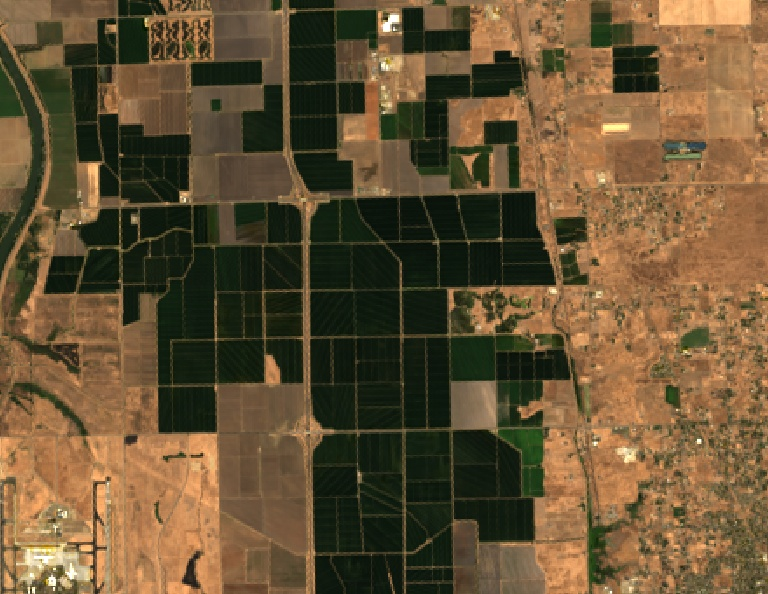

In [6]:
image_url = landsat_img.select([3, 2, 1]) \
    .getThumbURL({'min': 0.0, 'max': 3000, 
                  'region': test_region, 'dimensions': image_size})
Image(url=image_url, embed=True, format='png')

### Prep the raw Landsat SR image for use in DisALEXI

The prep function will rename the bands to generic names, compute albedo, ndvi, and extract the fmask image from the BQA band.

In [7]:
input_img = ee.Image(landsat.LandsatSR(landsat_img).prep())

Show the NDVI band for the validation asset area

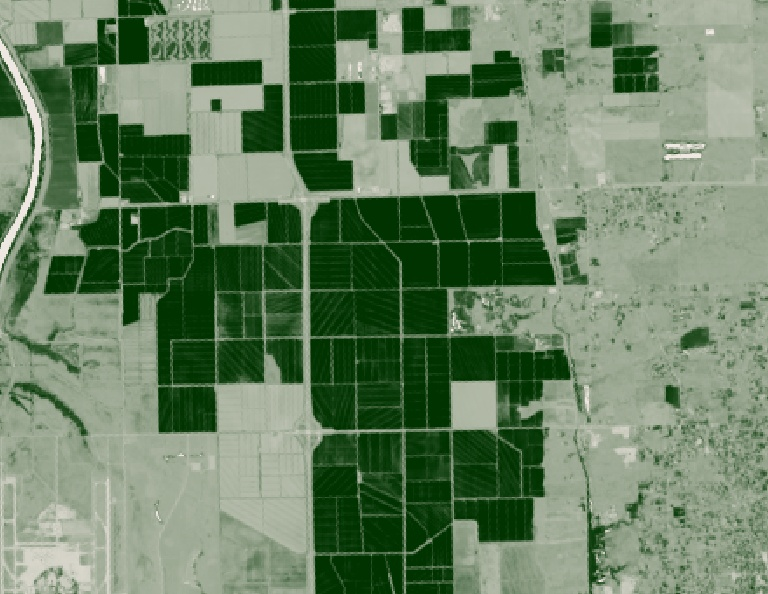

In [8]:
image_url = input_img.select(['ndvi']) \
    .getThumbURL({'min':-0.1, 'max':0.9, 'palette': ndvi_palette, 
                  'region': test_region, 'dimensions': image_size})
Image(url=image_url, embed=True, format='png')

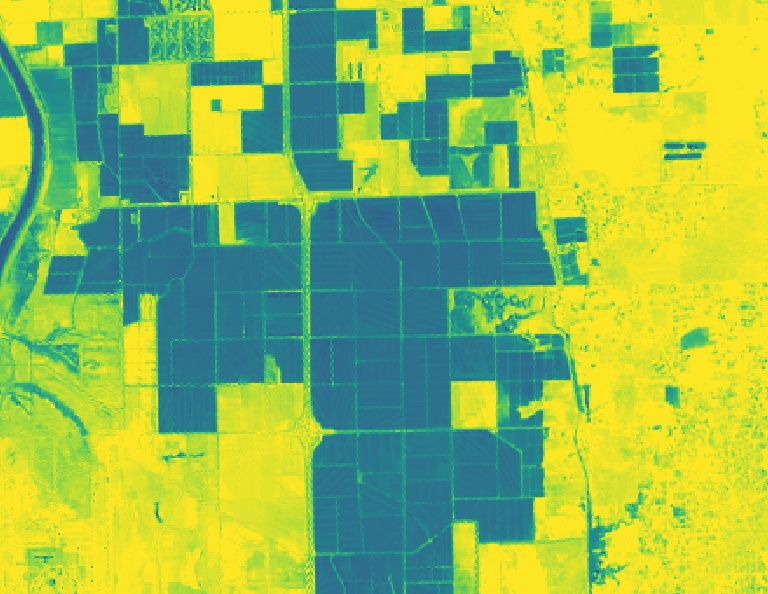

In [9]:
image_url = input_img.select(['lst']) \
    .getThumbURL({'min':295, 'max':325, 'palette': viridis_palette, 
                  'region': test_region, 'dimensions': image_size})
# print(image_url)
Image(url=image_url, embed=True, format='png')

### Extract input values at the test point

In [10]:
print('LAI:    {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['lai'])))
print('NDVI:   {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['lst'])))
print('CFMask: {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['cfmask'])))

LAI:      4.67970025
NDVI:     0.87439299
Albedo:   0.12599610
LST:    306.28910598 [K]
CFMask:   0.00000000


### Initialize the DisALEXI object

In [11]:
# Initialize the DisALEXI object (these are all the default values)
model_obj = disalexi.Image(
    input_img, 
    ta_source='CONUS_V001',
    alexi_source='CONUS_V001',
    elevation_source='USGS/SRTMGL1_003',
    landcover_source='NLCD2011',
    # landcover_source='GLOBELAND30',
    airpressure_source='CFSR',
    rs_daily_source='CFSR',
    rs_hourly_source='CFSR',
    windspeed_source='CFSR',
    vp_source='CFSR',
    stabil_iterations=36,
    albedo_iterations=10,
    ta_interp_flag=True,
    ta_smooth_flag=True,
    rs_interp_flag=True,
    et_reference_source='projects/climate-engine/cimis/daily', 
    et_reference_band='ETo_ASCE',
    et_reference_factor=1.0,
    et_reference_resample='nearest',
    # et_reference_source='IDAHO_EPSCOR/GRIDMET',
    # et_reference_band='eto',
    # et_reference_factor=0.85,
    # et_reference_resample='nearest',
)

### Extract the ancillary values at the test point

In [12]:
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.point_image_value(model_obj.et_alexi, xy=test_xy, scale=30)['et_alexi'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.point_image_value(model_obj.elevation, xy=test_xy, scale=30)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.point_image_value(model_obj.rs1, xy=test_xy, scale=30)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.point_image_value(model_obj.rs24, xy=test_xy, scale=30)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.point_image_value(model_obj.windspeed, xy=test_xy, scale=30)['windspeed'])))

ALEXI ET:     4.23587194 [mm]
Elevation:    3.00000000 [m]
Rs Hourly:  831.76146528 [W m-2]
Rs Daily:  8607.00000000 [W m-2]
Wind Speed:   2.87487536 [m/s]


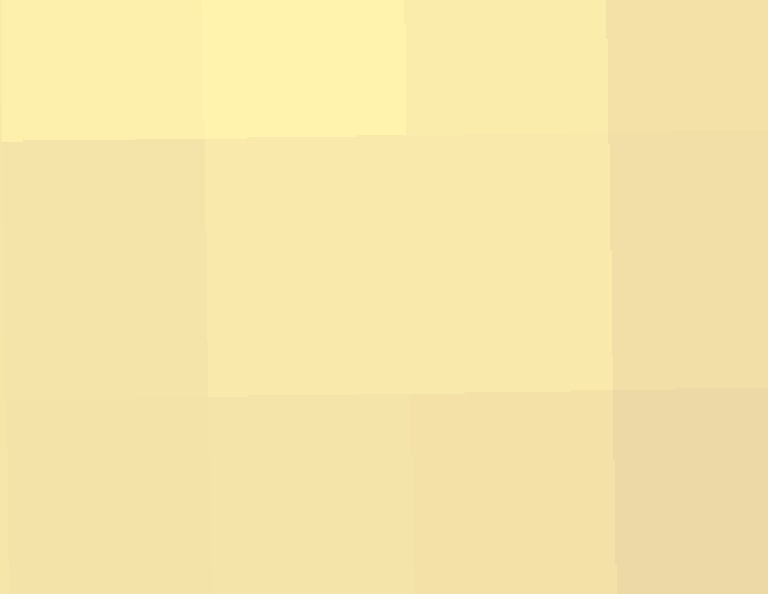

In [13]:
vis_img = model_obj.et_alexi \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .getThumbURL({'min':0, 'max':15, 'palette': ssebop_et_palette, 
                  'region': test_region, 'dimensions': image_size})
Image(url=vis_img, embed=True, format='png')

### Ta Asset ("smoothed" to Landsat scale)

This method is displaying the precomputed Ta asset for this image that has been resampled to the Landsat scale.

The smoothing is currently using the focal_mean function with a circle kernel and a radius of 2.

The ALEXI scale Ta is shown below but requires building the DisALEXI model object with ta_smooth_flag=False.

Ta: 302.36782488949603


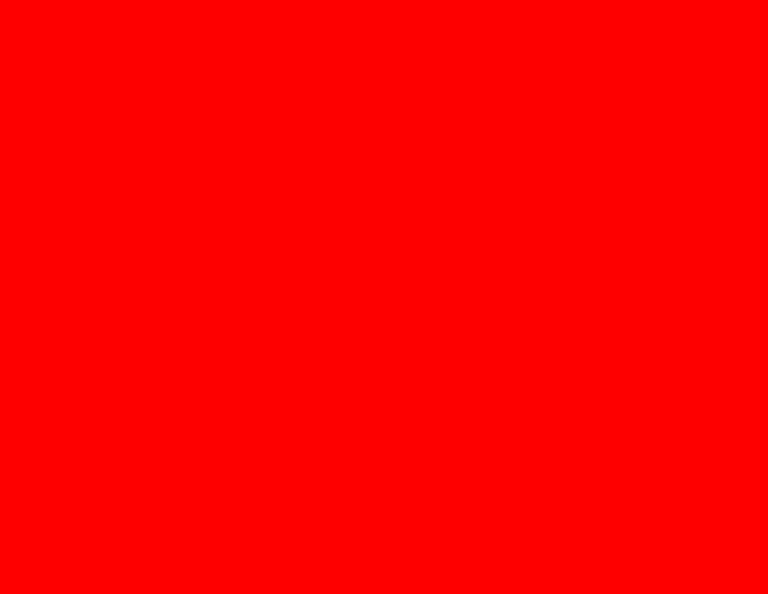

In [14]:
ta_img = model_obj.ta
print('Ta: {}'.format(pprint.pformat(utils.point_image_value(ta_img, xy=test_xy, scale=30)['ta'])))

ta_url = ta_img \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .getThumbURL({'min': 280, 'max': 300, 'palette': ','.join(jet_palette), 
                  'region': test_region, 'dimensions': image_size})
# print(ta_url)
Image(url=ta_url, embed=True, format='png')

### Compute ET

ET: 7.529309001832332


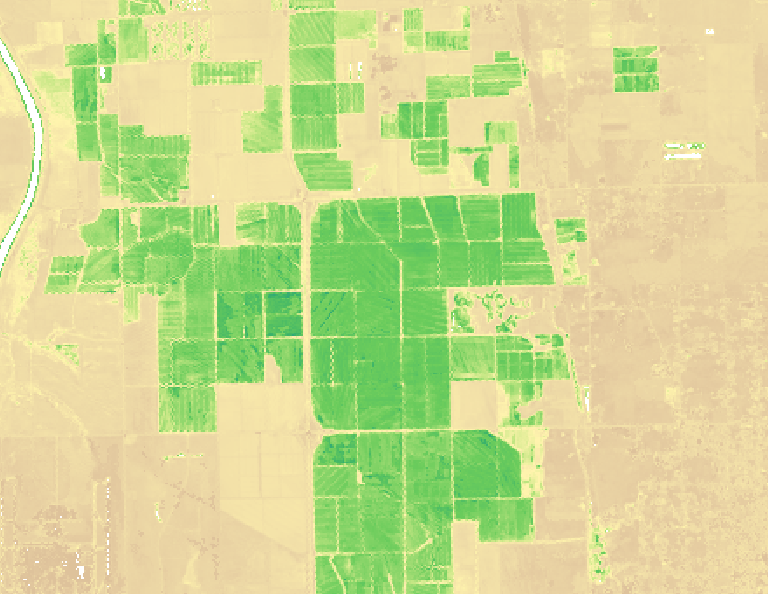

In [15]:
et_img = model_obj.et
print('ET: {}'.format(pprint.pformat(utils.point_image_value(et_img, xy=test_xy, scale=30)['et'])))

et_url = et_img \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .getThumbURL({'min': 0, 'max': 15, 'palette': ','.join(ssebop_et_palette), 
                  'region': test_region, 'dimensions': image_size})
# print(et_url)
Image(url=et_url, embed=True, format='png')

### Compare ET to test assets

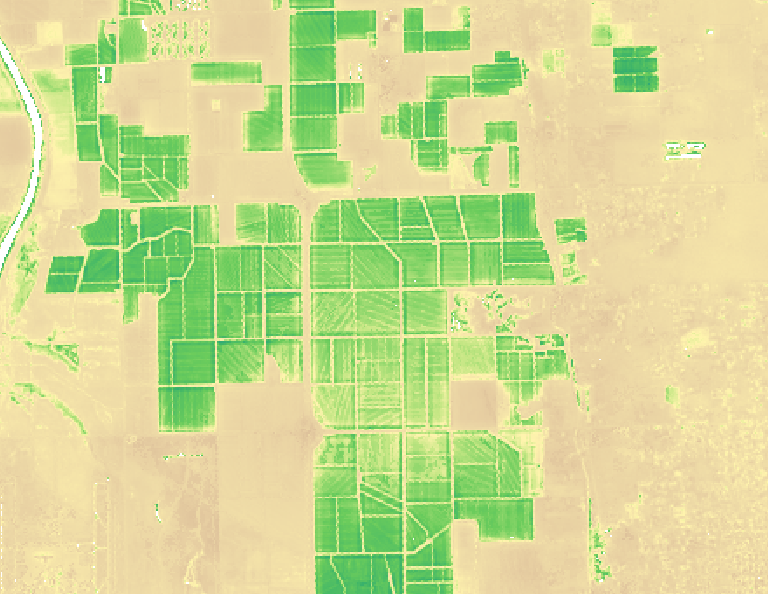

In [16]:
et_test_img = ee.Image('projects/openet/test/DisALEXI/Borden/Landsat/ETd_2017197_landsat') \
    .rename(['et'])
# print('ET: {}'.format(pprint.pformat(utils.point_image_value(et_img, xy=test_xy, scale=30)['et'])))

et_test_url = et_test_img \
    .getThumbURL({'min': 0, 'max': 15, 'palette': ','.join(ssebop_et_palette),
                  'region': test_region, 'dimensions': image_size})
Image(url=et_test_url, embed=True, format='png')

### Ta Asset (ALEXI scale)

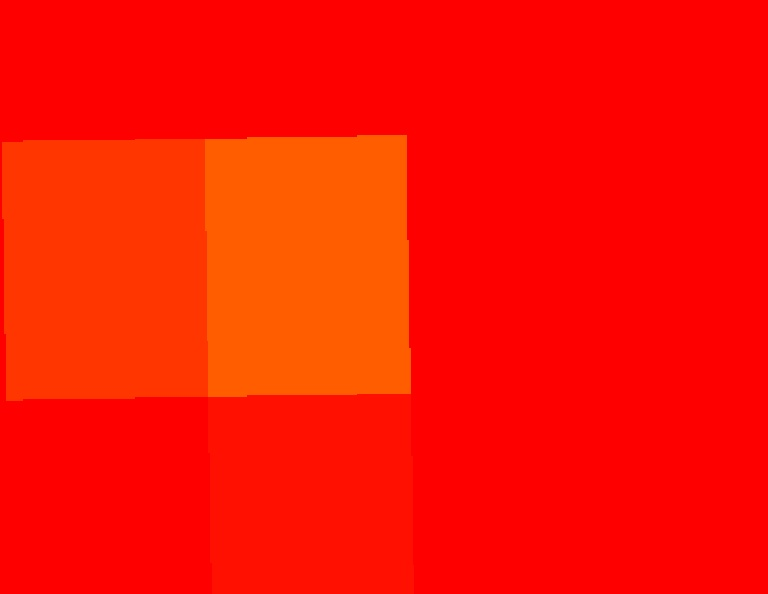

In [17]:
# Same as above but set ta_smooth_flag to False
ta_url = disalexi.Image(input_img, ta_smooth_flag=False).ta \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .getThumbURL({'min': 280, 'max': 300, 'palette': ','.join(jet_palette), 
                  'region': test_region, 'dimensions': image_size})
Image(url=ta_url, embed=True, format='png')

### Compute Air Temperature

The air temperature asset is created by iteratively calling the ta_coarse and ta_bias methods

In [18]:
# image_transform = ee.Image(landsat_img).select('B2').projection().getInfo()['transform']
# print(image_transform)

# # Reduce the computation resolution
# image_transform = '[' + ','.join(map(str, [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0])) + ']'
# # output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
# image_transform = [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]
# print(image_transform)

In [19]:
# t_air_img = ee.Image(model_obj.ta_qm(cellsize=120, ta_values=list(range(250, 351, 1))))
# print('Output Ta:\n{}'.format(pprint.pformat(
#     utils.image_value(t_air_img, xy=test_xy, scale=120)['ta'])))
# # print('Output Ta:\n{}'.format(pprint.pformat(
# #     utils.image_value(t_air_img, xy=test_xy, crs=image_crs, crsTransform=image_transform)['ta'])))

In [20]:
# t_air_url = t_air_img.getThumbURL({
#     'region': test_region, 'min':270, 'max':330})
# print(t_air_url)

In [21]:
# Image(url=t_air_url, embed=True, format='png')